In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import pearsonr
import pandas as pd

In [2]:
def read_mesh(filename):
    #vertices: np array with the coordinates of each vertex
    #faces: np array with the three vertices that forms the face
    #conexions: set of faces around each vertex
    #edegs: set of vertex around each vertex

    mesh = open(filename)
    n, m = mesh.readline().split()
    n = int(n)
    m = int(m)
    vertices = []
    faces = []
    conexions = [set() for i in range(n)]
    edges = [set() for i in range(n)]

    for i in range(n):
        vertices.append(mesh.readline().split())
        for j in range(3):
            vertices[i][j] = float(vertices[i][j])

    for i in range(m):
        faces.append(mesh.readline().split())
        for j in range(3):
            faces[i][j] = int(faces[i][j]) - 1
            conexions[faces[i][j]].add(i)
            for k in range(j-1,-1,-1):
                edges[faces[i][j]].add(faces[i][k])
                edges[faces[i][k]].add(faces[i][j])

    return np.array(vertices), np.array(faces) , conexions , edges


def get_normal(vertices, faces):
    # Gets the normal vector for all the faces
    normal = []
    area = []
    for face in faces:
        v1 = vertices[face[1]] - vertices[face[0]]
        v2 = vertices[face[2]] - vertices[face[0]]
        n = np.cross(v1, v2)
        a = np.sqrt(np.dot(n, n))
        area.append(a)
        normal.append(n / a)
    return np.array(normal), np.array(area)

In [3]:
def read_data( phi , N ):
    directions_file = open("output_phi/directions_" + str(phi) + ".txt", "r")
    normals_file = open("output_phi/normals_" + str(phi) + ".txt", "r")
    directions = []
    normals = []
    for i in range(N):
        directions.append(directions_file.readline().split())
        normals.append(normals_file.readline().split())
        for j in range(3):
            directions[i][j] = float(directions[i][j])
            normals[i][j] = float(normals[i][j])
    directions_file.close()
    normals_file.close()
    return np.array(directions) , np.array(normals)

In [4]:
def read_char( phi , theta , norm ):
    #normals_file = open( "output_char/normals_"+str(phi)+"_"+str(theta)+".txt" , "r" )
    normals = []
    for line in open( "output_char/normals_"+str(phi)+"_"+str(theta)+".txt" , "r" ):
        normals.append(line.split())
        if len(normals[-1]) == 1:
            normals[-1] = norm[int(normals[-1][0])]
        elif len(normals[-1]) == 3:
            for j in range(3):
                normals[-1][j] = float(normals[-1][j])
    print( len(normals ) )
    return np.array( normals )

In [5]:
def read_part( r , phi , theta , faces , conexions , norm ):
    #normals_file = open( "output_part/normals_" + str(r) + "_" + str(phi) + "_" + str(theta) + ".txt" , "r" )
    normals = []
    for line in open( "output_part/normals_" + str(r) + "_" + str(phi) + "_" + str(theta) + ".txt" , "r" ):
        line = line.split()
        if line[0] == "0": 
            faces = np.array( list( conexions[int(line[1])] ) )
            faces = norm[ faces ]
            n = sum( faces )/len(faces)
            normals.append( n ) 
        elif line[0] == "1":
            face = int(line[1])
            normals.append( norm[face] )
        elif line[0] == "2":
            faces = np.array(  list( conexions[int(line[1])].intersection( conexions[int(line[2])] ) ) )
            faces = norm[ faces ]
            n = sum( faces )/len(faces)
            normals.append( n )             

    return normals

In [6]:
def read_spheric( r , phi , theta ):
    nphi = []
    ntheta = []
    for line in open( "output_part/normals/spheric_" + str(r) + "_" + str(phi) + "_" + str(theta) + ".txt" , "r" ):
        line = line.split()
        nphi.append( float(line[0]) )
        ntheta.append( float(line[1]) )
    return nphi , ntheta

In [7]:
def spheric_angles( vectors ):
    #Converts the vectors in cartessian coordinates into spheric coordinates
    x = np.array([1, 0, 0]);
    y = np.array([0, 1, 0]);
    z = np.array([0, 0, 1])
    phi = [];
    theta = []
    for n in vectors:
        n = n / np.sqrt(np.dot(n, n))
        phi.append(np.arccos(np.dot(z, n)) / np.pi * 180)
        n[2] = 0;
        n = n / np.sqrt(np.dot(n, n))
        vx = np.dot(x, n);
        vy = np.dot(y, n)
        if vy >= 0:
            theta.append(np.arccos(vx) / np.pi * 180)
        else:
            theta.append(-np.arccos(vx) / np.pi * 180)
    return np.array(phi), np.array(theta)    

In [8]:
def spheric_angles_dir( normal , d ):
    #Converts
    x = np.array([1, 0, 0]); y = np.array([0,1,0]); z = np.array([0,0,1])
    phi = []; theta = []
    for i,n in enumerate(normal):
        n = n / np.sqrt(np.dot(n, n))
        x = np.array([ d[0] , d[1] , 0 ])
        x = x / np.sqrt(np.dot(x, x))
        y = np.array([ x[1] , -x[0] , 0 ])
        phi.append(np.arccos(np.dot( z , n ) )/np.pi*180)
        n[2] = 0; n = n / np.sqrt(np.dot(n,n))
        vx = np.dot( x , n ); vy = np.dot( y , n )
        if vy >= 0:
            theta.append( np.arccos(vx)/np.pi*180)
        else:
            theta.append( -np.arccos(vx)/ np.pi * 180)
    return np.array(phi), np.array(theta)

In [9]:
def bouncings( normal , direction ):
    bounces = []
    for i in range( len(normal) ):
        n = normal[i]
        d = direction[i]
        d = d / np.sqrt(np.dot(d, d))
        bounces.append(bounce(n,d))
    return np.array(bounces)

def bounce( n , x ):
    # return elastic colission of x in n
    R = 2*np.kron( n , n ).reshape((3,3))-np.identity(3)
    return np.matmul( R , -x )

In [10]:
def plot_spheric( phi , theta , phi1 ):
    #plt.plot(phi, theta, "ko", markersize=1 )
    #plt.xlim( -5 , 90 )
    #plt.title("Incidence phi = " + str(p))
   # plt.xlabel("phi")
    #plt.ylabel("theta")
    #plt.grid()

    #par_theta = np.linspace( -180 , 180 , 100 )
    #par_phi = np.arctan( -1./np.cos(par_theta/180*np.pi)/np.tan(phi1/180*np.pi) )
    #par_phi[par_phi < 0 ] = par_phi[par_phi<0] +np.pi
    #plt.plot( (par_phi/np.pi*180) , par_theta , "r" )
    
    #plt.show()

    pd.DataFrame(phi).plot(kind='density', color="black", xlim=(0, 100))
    plt.grid()
    plt.title("Incidence phi = " + str(phi1))
    plt.xlabel("phi")
    plt.legend(["density"])
    plt.show()

    pd.DataFrame(theta).plot(kind='density', color="black", xlim=(-190, 190))
    plt.plot(np.linspace(-180, 180, 200), np.ones(200) / 360, color="red")
    plt.grid()
    plt.title("Incidence phi = " + str(phi1))
    plt.xlabel("theta")
    plt.legend(["density", "uniform distribution"])
    plt.show()

In [11]:
def plot_hystogram( phi1 , phi , theta , l ): #, weights ):
    hystogram = np.zeros( (int(np.ceil(120/l)) , int(np.ceil((360+l)/l))) )
    for i in range( len(phi) ):
        hystogram[ int(np.floor(phi[i]/l)) , int(np.floor((theta[i]+180)/l)) ] += 1.#/np.sin(phi[i]/180*np.pi) #weights[ i ] 
        
    hystogram = hystogram/float(len(phi))
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow( hystogram[:,:-1].transpose() , cmap = "jet" , extent = [0,120,-180,180] , vmin = 0 , vmax = 0.005 ) #grey
    
    par_theta = np.linspace( -180 , 180 , 100 )
    par_phi = np.arctan( -1./np.cos(par_theta/180*np.pi)/np.tan(phi1/180*np.pi) )
    par_phi[par_phi < 0 ] = par_phi[par_phi<0] +np.pi
    plt.plot( (par_phi/np.pi*180) , (par_theta) , "r" )

    plt.colorbar()
    plt.show()
    
    return hystogram

In [12]:
vertices, faces, conexions , edges = read_mesh("input/mucus_large.txt")
normal, faces_area = get_normal(vertices, faces)

In [17]:
r = 50
phi = 60
theta = 0
ns=[]
for line in open( "output_part/normals_" + str(r) + "_" + str(phi) + "_" + str(theta) + ".txt" , "r" ):
    ns.append(line.split())
    
n = read_part( r , phi , theta , faces , conexions , normal )
dir = np.array( [ -np.sin(phi/180*np.pi)*np.cos(theta/180*np.pi),- np.sin(phi/180*np.pi)*np.sin(theta/180*np.pi) , np.cos(phi/180*np.pi)])
nphi, ntheta = spheric_angles_dir( n.copy() , dir)

for i in range( len(ns) ):
    if (np.tan(nphi[i]/180*np.pi)**2)*(np.cos(ntheta[i]/180*np.pi)**2) >  1./np.tan(phi/180*np.pi)**2:
        print( nphi[i] , ntheta[i] )
        if ns[i][0] == "0":
            print( ns[i][0] , vertices[int(ns[i][1])] )
        if ns[i][0] == "2":
            print( ns[i][0] , vertices[int(ns[i][1][0])] ,  vertices[int(ns[i][1][1])])
        if ns[i][0] == "1":
            print( ns[i][0] , vertices[faces[int(ns[i][1])][0]] , vertices[faces[int(ns[i][1])][1]] , vertices[faces[int(ns[i][1])][2]] )

33.00381400146652 21.992304975768793
0 [ 35.94028035 471.61478992  21.34632746]
33.00381400146652 21.992304975768793
0 [ 35.94028035 471.61478992  21.34632746]
30.484208326534375 9.598938701147864
0 [ 52.40803106 565.36923607  20.27425843]
42.60484931495033 -1.3427548222517491
0 [103.64840777 613.64703995  19.72277371]
36.08747763423363 -34.58267485529729
0 [146.27782676 715.7534058   19.07831117]
36.08747763423363 -34.58267485529729
0 [146.27782676 715.7534058   19.07831117]
36.08747763423363 -34.58267485529729
0 [146.27782676 715.7534058   19.07831117]
36.08747763423363 -34.58267485529729
0 [146.27782676 715.7534058   19.07831117]
36.08747763423363 -34.58267485529729
0 [146.27782676 715.7534058   19.07831117]
36.08747763423363 -34.58267485529729
0 [146.27782676 715.7534058   19.07831117]
30.657179873871243 -173.7608640944622
0 [ 40.696769   872.29468974  19.48926301]
30.657179873871243 -173.7608640944622
0 [ 40.696769   872.29468974  19.48926301]


In [19]:
for r in [1,2,5,10,25,50]:
    for phi in [ 60 ]:
        theta = 0
        n = read_part( r , phi , theta , faces , conexions , normal )
        dir = np.array( [ -np.sin(phi/180*np.pi)*np.cos(theta/180*np.pi), np.sin(phi/180*np.pi)*np.sin(theta/180*np.pi) , -np.cos(phi/180*np.pi)])
        nphi, ntheta = spheric_angles_dir( n.copy() , dir)
        spheric = open( "output_part/normals/spheric_" + str(r) + "_" + str(phi) + "_" + str(theta) + ".txt" , "w" )
        for i in range(len(nphi)):
            spheric.write( str(nphi[i]) + " " + str(ntheta[i]) + "\n" ) 

0


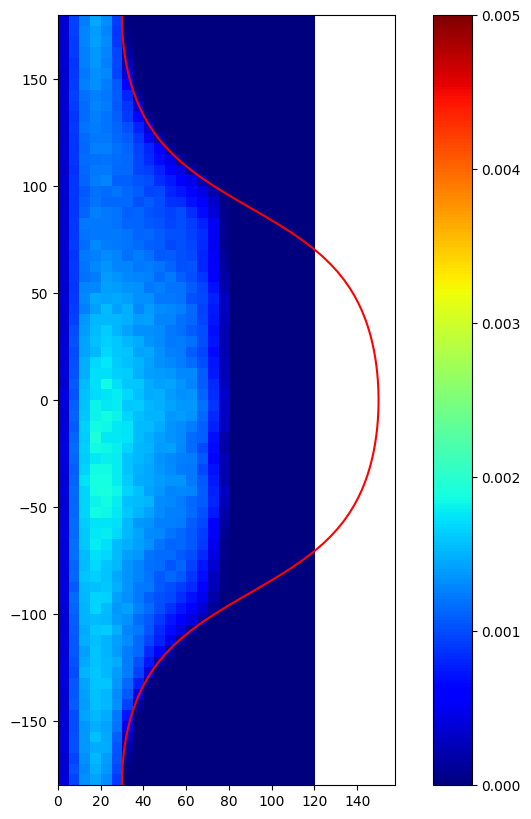

1


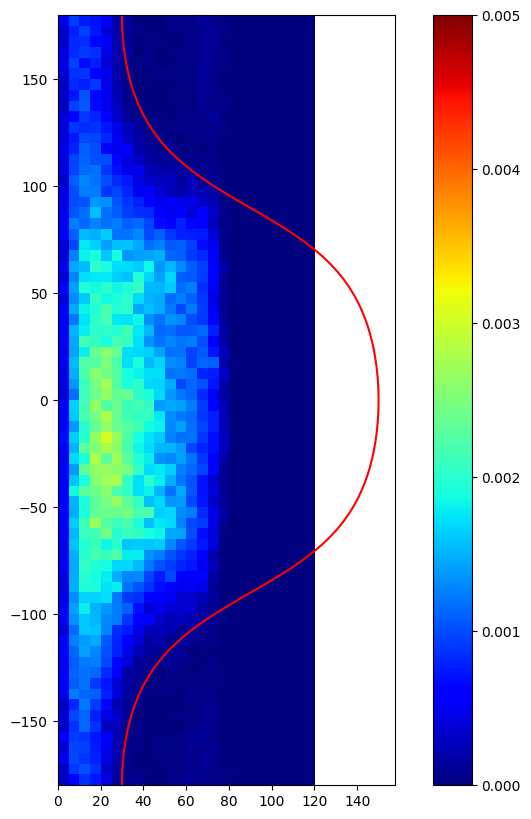

2


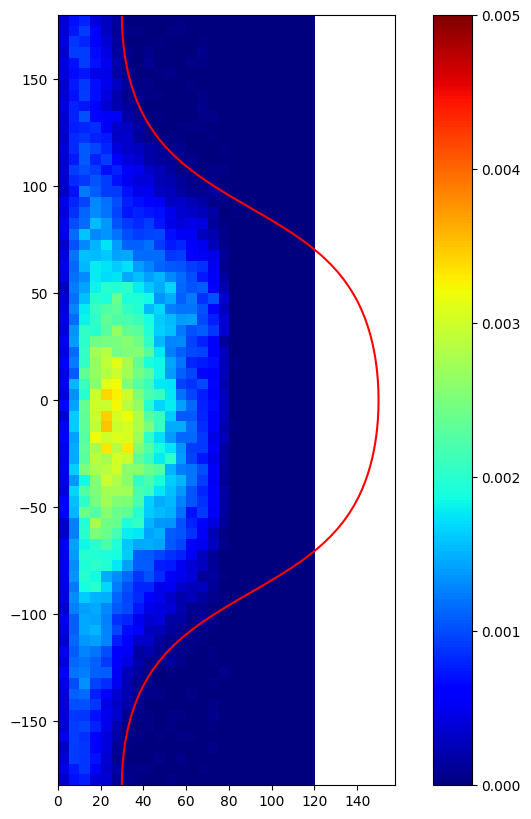

5


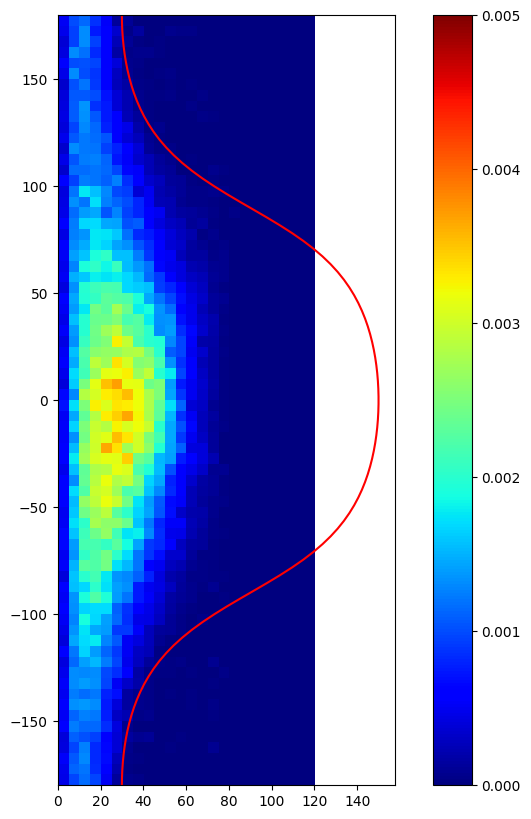

10


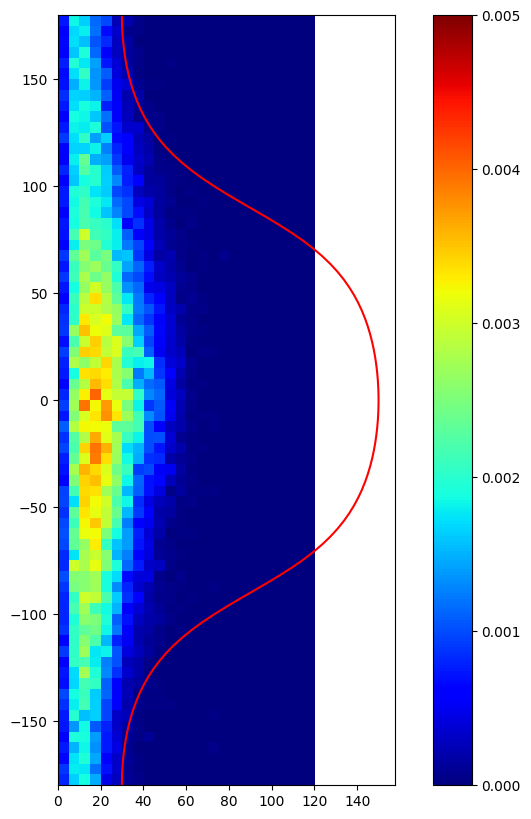

25


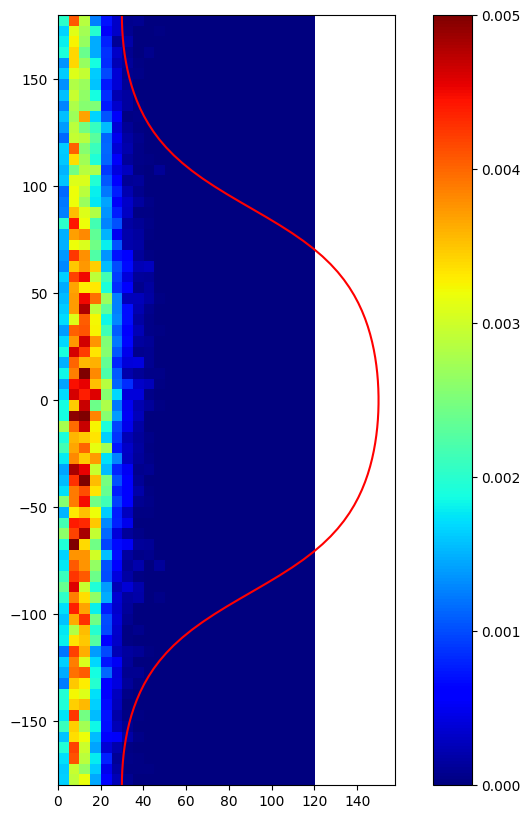

50


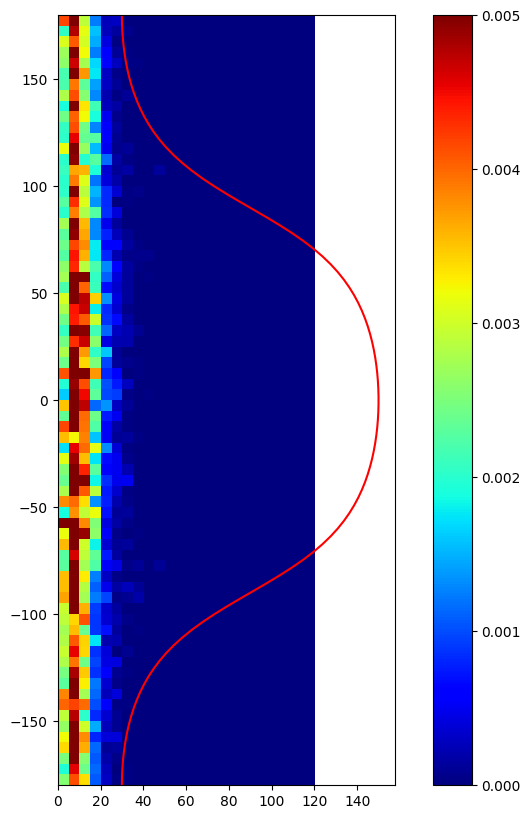

In [16]:
for r in [0,1,2,5,10,25,50]:
    phi = 60
    theta = 0 
    #n = read_part( r , phi , theta , faces , conexions , normal )
    dir = - np.array( [ np.sin(phi/180*np.pi)*np.cos(theta/180*np.pi), np.sin(phi/180*np.pi)*np.sin(theta/180*np.pi) , np.cos(phi/180*np.pi)])
    #nphi, ntheta = spheric_angles_dir( n.copy() , dir)
    nphi , ntheta = read_spheric( r , phi , theta )
    hystogram = plot_hystogram( phi , nphi , ntheta , 5 )
    #plot_spheric( nphi , ntheta , phi )

In [ ]:
for i in range( 0,20 , 2):
    plt.plot( hystogram[i , : -1] )
    plt.show()

In [ ]:
p = 60
directions , normals = read_data( p , 1000 ) 
phi, theta = spheric_angles(normals.copy() , directions.copy() )
bounces = bouncings(normals.copy(), directions.copy() )
bphi, btheta = spheric_angles(bounces.copy() , directions.copy())

In [ ]:
normal_phi, normal_theta = spheric_angles_dir( normal.copy() , np.array([1,0,0] ) )
#w = faces_area * ( np.dot( normal , np.array([0,0,1] ) ) )
normal_hyst = plot_hystogram( 0 , normal_phi , normal_theta , 1 )

In [ ]:
for i in range( 0,60 , 5):
    plt.plot( normal_hyst[i , : ] )
    plt.ylim( 0 , 260 )
    plt.show()

In [15]:
for phi in [ 60 ]:
    theta = 0
    theta_char = str(theta)+"2"
    p = phi
    r = 0
    n = read_char( phi , theta_char , normal )
    dir = np.array( [ np.sin(phi/180*np.pi)*np.cos(theta/180*np.pi), np.sin(phi/180*np.pi)*np.sin(theta/180*np.pi) , np.cos(phi/180*np.pi)])
    nphi, ntheta = spheric_angles_dir( n.copy() , dir)
    spheric = open( "output_part/normals/spheric_" + str(r) + "_" + str(phi) + "_" + str(0) + ".txt" , "w" )
    for i in range(len(nphi)):
        spheric.write( str(nphi[i]) + " " + str(-ntheta[i]) + "\n" ) 
    print( phi )

3106857
60


In [ ]:
hystogram = plot_hystogram( p , nphi , ntheta , 5 )

In [ ]:
phi , thetas = 60 , [0,45,90,135,180,225,270,315]
p = phi
l = 1 
h = np.zeros( (int(np.ceil(120/l)) , int(np.ceil(361/l))) )
for theta in thetas:
    print( "Theta = " , theta )
    theta_char = str(theta)+"2"
    n = read_char( phi , theta_char , normal )
    dir = np.array( [ np.sin(phi/180*np.pi)*np.cos(theta/180*np.pi), np.sin(phi/180*np.pi)*np.sin(theta/180*np.pi) , np.cos(phi/180*np.pi)])
    nphi, ntheta = spheric_angles_dir( n.copy() , dir)
    hystogram = plot_hystogram( p , nphi , ntheta , l )
    h += hystogram

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.imshow( h.transpose() , cmap = "jet") #grey
plt.show()

In [ ]:
for i in range( 0,90 , 5):
    print( i )
    plt.plot( h[i , : ] )
    plt.show()

In [ ]:
hystogram = plot_hystogram( p , nphi , ntheta , 2 )

In [ ]:
for i in range( 0,20 , 3):
    plt.plot( hystogram[i , : ] )
    plt.ylim( 0 , 1000 )
    plt.show()

In [ ]:
plot_spheric( nphi , ntheta , p )